In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [2]:
np.random.seed(123)

In [3]:
def plot_means(ein1, ein2, eout1, eout2, iters, title, neg, pos, w=None, b=None, moons=False, poly=False, poly_weights=None):
    T = [i for i in range(iters)]
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) # nrows=1, ncols=3, sharex=True,figsize=(12, 6)
   
    axs[0].set(title=title)
    axs[0].plot([i for i in range(len(ein1))],ein1,linewidth = 2.0, c='red', label='$E_{in}(w)$')
    axs[0].plot([i for i in range(len(eout1))],eout1,linewidth = 2.0, c='green', label='$E_{out}(w)$')
    axs[0].set_xlabel('T')
    axs[0].set_ylabel('$E_{in}(w), E_{out}(w)$')
    axs[0].grid(True)
    axs[0].legend(loc='best')

    axs[1].plot([i for i in range(len(ein2))],ein2,linewidth = 2.0, c='red', label='$E_{in}(\overline{w})$')
    axs[1].plot([i for i in range(len(eout2))],eout2,linewidth = 2.0, c='green', label='$E_{out}(\overline{w})$')
    axs[1].set_xlabel('T')
    axs[1].set_ylabel('$E_{in}(\overline{w}), E_{out}(\overline{w})$')
    axs[1].grid(True)

    axs[1].legend(loc='best')
    
    
    if moons and not poly:
        axs[2].scatter(neg[:,0],neg[:,1], s=10, c=pos, cmap=plt.cm.Spectral, label='circles')
        
    elif moons and poly:
        x = np.arange(-1, 2.0, 0.1)

        y_l = (poly_weights[0]+(poly_weights[1])*x+(poly_weights[3])*x**2+(poly_weights[6])*x**3)/-(poly_weights[2]+poly_weights[4]+poly_weights[5]+poly_weights[7])

        ydata = y_l 
        axs[2].scatter(neg[:,0], neg[:,1], s=10, c=pos, cmap=plt.cm.Spectral)

        axs[2].plot(x, ydata,  'b', label='poly')

        
    
    else:
    
        axs[2].scatter(neg[:,0],
                neg[:,1],
                c='salmon',
                label='1')

        axs[2].scatter(pos[:,0],
                    pos[:,1],
                    c='mediumturquoise',
                    label='-1')

    if w is not None and b is not None:
        x1 = np.array([0, 1])
        x2 = -(w[0] * x1 + b)/w[-1]
        axs[2].axline(xy1=(x1[0], x2[0]), xy2=(x1[1], x2[1]))

    axs[2].legend(loc='right')
   
    fig.tight_layout()
    plt.show()
    
    

In [4]:
class PocketPerceptron():
    def __init__(self, w=None, y_classes=None, poly=False, degree=None):
        self.w = w
        self.y_classes = y_classes
        self.result_iters = None
        self.poly = poly
        self.degree=degree


    def fit(self, X, y, iterations=1000, seed=None):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

        
        N = X.shape[0]
        d = X.shape[1]
        
        y_classes = np.unique(y_train)
        y01 = (y_train == y_classes[1]).astype('int64')
        
        y02 = (y_test==y_classes[1]).astype('int64')

        gen = np.random.default_rng(seed)
        
        
        if self.poly:
            pol = PolynomialFeatures(degree=self.degree)

            X1 = pol.fit_transform(X_train)
            X2 = pol.fit_transform(X_test)
        
        
        else:        
            X1 = np.insert(X_train, X_train.shape[1], 1, axis=1)
            X2 = np.insert(X_test, X_test.shape[1], 1, axis=1)
        
        w_current = np.repeat(0, X1.shape[1])
        w_pocket = np.repeat(0, X1.shape[1])
        
         
        Ein_curr = 0
        Ein_pocket = 0
        
        Eout_curr = 0
        Eout_pocket = 0
        
        ein_curr_avg = []
        ein_pocket_avg = []
        
        eout_curr_avg = []
        eout_pocket_avg = []
        
        
        for i in range(iterations):
            yhat = (np.sign(X1.dot(w_current))+1)/2 
            Ein_curr = np.mean(yhat == y01)

            y_out_pred = (np.sign(X2.dot(w_current))+1)/2 
            Eout_curr = np.mean(y_out_pred==y02)
            
            if Ein_curr == 1:
                w_pocket = w_current
                Ein_pocket = Ein_curr
                
                Eout_pocket = Eout_curr
                self.result_iters=i
                break
                                
            elif Ein_curr > Ein_pocket:
                w_pocket = w_current
                Ein_pocket = Ein_curr
                
                Eout_pocket = Eout_curr
                

            # берем рандомный неверно классифицированный пример и с помощью него изменяем веса 
            missclassified_idxs = np.nonzero(yhat != y01)[0]
            p = gen.choice(missclassified_idxs, size=1)[0]
            w_current = w_current + (X1[p] if y01[p] == 1 else -X1[p])
            
            ein_curr_avg.append(1-Ein_curr)
            ein_pocket_avg.append(1-Ein_pocket)

    
            eout_curr_avg.append(1-Eout_curr)    
            eout_pocket_avg.append(1-Eout_pocket)             
            self.result_iters=i
            

        self.w = w_pocket
        self.y_classes = y_classes
        
        return ein_curr_avg, ein_pocket_avg, eout_curr_avg, eout_pocket_avg

    def predict(self, X):
        X1 = np.insert(X, X.shape[1], 1, axis=1)
        yhat = (X1.dot(self.w) > 0).astype('int64')
        preds = self.y_classes[yhat]

        return preds


In [5]:
class Perceptron(object):
    def __init__(self, eta=1, n_iter=1000):
        self.eta=eta
        self.n_iter = n_iter
    
    def activation_fn(self, x):
        return 1 if x >= 0 else 0
    
    def predict(self, x):
        z = self.W.T.dot(x)
        a = self.activation_fn(z)
        return a
    
    def output(self,x):
        return np.dot(x,self.w)+self.b
    
    def fit(self, X, d):
        self.w=np.ones(X.shape[1])
        self.b=0
        self.errors=[]
        
        for _ in range(self.n_iter):
            error=0
                       
            for x_i, target in zip(X,y):
                if target*self.output(x_i)<0:
                    self.w+=self.eta*target*x_i
                    self.b+=self.eta*target
                    error+=1
                    
            self.errors.append(error)
            
            if error==0:
                break
                
        return self

In [6]:
def make_moons(n_samples=100, noise=None, s=5):
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - (1+s/10)#.5

    X = np.vstack((np.append(outer_circ_x, inner_circ_x),
                   np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n_samples_in, dtype=np.intp),
                   np.ones(n_samples_out, dtype=np.intp)])

    if not noise is None:
        X += np.random.normal(scale=noise, size=X.shape)

    return X, y

### Перцептрон

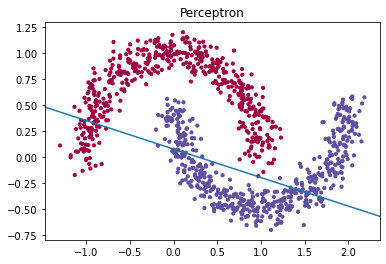

In [7]:
X, y = make_moons(1000, noise=0.1, s=-5)
y=np.where(y==0, -1, 1)

perceptron = Perceptron()
perceptron.fit(X, y)   

plt.scatter(X[:,0],X[:,1], s=10, c=y, cmap=plt.cm.Spectral, label='circles')
      
x1 = np.array([0, 1])
x2 = -(perceptron.w[1] * x1 + perceptron.w[0])/perceptron.b
plt.axline(xy1=(x1[0], x2[0]), xy2=(x1[1], x2[1]))
plt.title('Perceptron')

plt.show()

### Карманный алгоритм

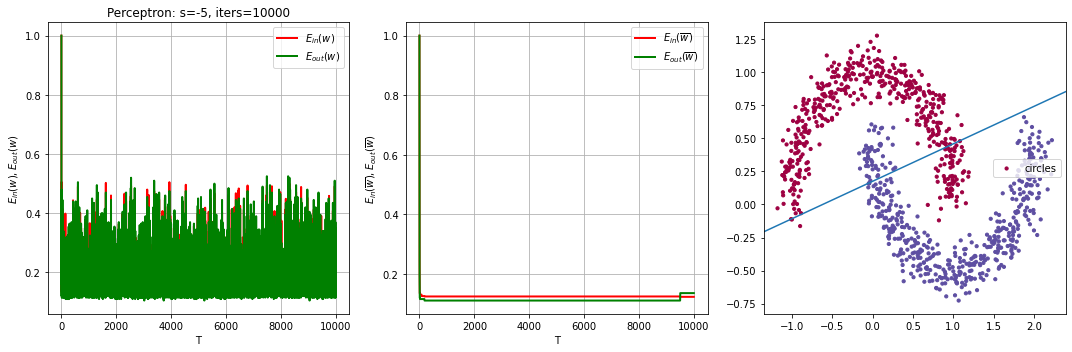

In [8]:
X, y = make_moons(1000, noise=0.1, s=-5)
y=np.where(y==0, -1, 1)

p=PocketPerceptron()
ein1, ein2, eout1, eout2=p.fit(X = X, y = y, iterations=10000)
w = p.w[:-1]
b = p.w[-1]

plot_means(ein1, ein2, eout1, eout2, p.result_iters+1, 
           f'Perceptron: s={-5}, iters={p.result_iters+1}', X, y, w, b, True)

### Полиномиальное преобразование 3-го порядка

In [9]:
X, y = make_moons(1000, noise=0.1, s=-5)
y=np.where(y==0, -1, 1)

p=PocketPerceptron(poly=True, degree=3)
ein1, ein2, eout1, eout2=p.fit(X = X, y = y, iterations=10000)

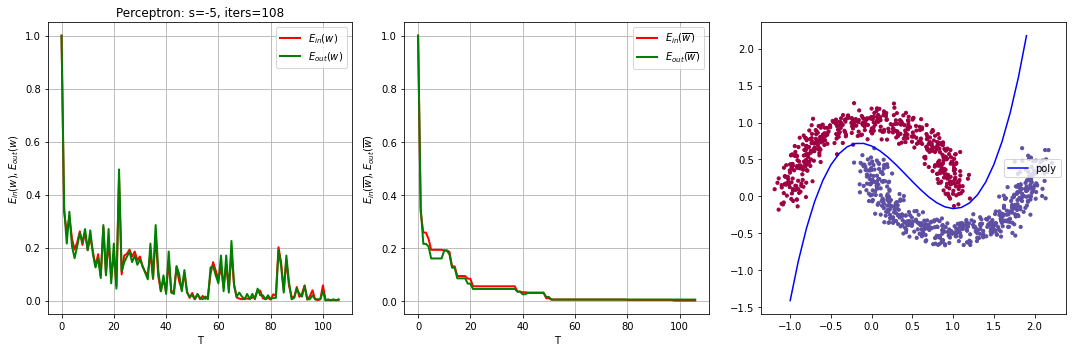

In [10]:
plot_means(ein1, ein2, eout1, eout2, p.result_iters+1, 
           f'Perceptron: s={-5}, iters={p.result_iters+1}', X, y, moons=True, poly=True, poly_weights = p.w) 
